In [1]:
import os

In [2]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection\\Pretrained Models\\MobileNetV3'

In [3]:
os.chdir("../")
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\manob\\Documents\\Kidney_Disease_Detection\\Kidney_Disease_Detection'

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.utils import custom_object_scope
import matplotlib.pyplot as plt

c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\manob\Documents\Kidney_Disease_Detection\Kidney_Disease_Detection\.conda\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [6]:
# Configuration for Kidney Stone Detection with MobileNetV3
BASE_DIR = "artifacts/data_ingestion/Combined_Training_Data"  # Directory containing Stone and Non-Stone folders
MODEL_PATH = "Pretrained Models/MobileNetV3/mobilenetv3_kidney_stone_model.h5"  # Path to the model we just created
SAVE_BEST_MODEL_PATH = "Pretrained Models/MobileNetV3/mobilenetv3_kidney_stone_model_trained.h5"  # Path to save the trained model

# Improved hyperparameters for better performance
IMAGE_SIZE = (320, 320)  # Increased image size for better feature detection
BATCH_SIZE = 8  # Even smaller batch size for better generalization
INITIAL_LEARNING_RATE = 1e-4  # Slightly higher learning rate to start
EPOCHS = 50  # More epochs for better convergence

# Create a directory to save training plots
PLOTS_DIR = "Pretrained Models/MobileNetV3/training_plots"
os.makedirs(PLOTS_DIR, exist_ok=True)

# Check class balance to determine class weights
stone_dir = os.path.join(BASE_DIR, 'Stone')
non_stone_dir = os.path.join(BASE_DIR, 'Non-Stone')
stone_count = len(os.listdir(stone_dir))
non_stone_count = len(os.listdir(non_stone_dir))
total_count = stone_count + non_stone_count

print(f"Stone images: {stone_count} ({stone_count/total_count:.2%})")
print(f"Non-Stone images: {non_stone_count} ({non_stone_count/total_count:.2%})")

# Calculate class weights to handle imbalance
weight_for_0 = (1 / non_stone_count) * (total_count / 2.0)  # For Non-Stone class
weight_for_1 = (1 / stone_count) * (total_count / 2.0)  # For Stone class

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Class weights: {class_weight}")

Stone images: 18194 (46.87%)
Non-Stone images: 20627 (53.13%)
Class weights: {0: 0.9410239007126582, 1: 1.066862701989667}


In [7]:
# Enhanced data generators with specialized medical imaging augmentation
# First, create a preprocessing function for contrast enhancement
def preprocess_ct_image(img):
    # Convert to float
    img = img.astype('float32')
    
    # Normalize to [0,1]
    img = img / 255.0
    
    # Apply contrast stretching - enhance the contrast of CT images
    p2, p98 = np.percentile(img, (2, 98))
    img = np.clip((img - p2) / (p98 - p2), 0, 1)
    
    return img

# Use standard ImageDataGenerator with preprocessing function
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_ct_image,  # Apply CT-specific preprocessing
    validation_split=0.2,  # 20% of data for validation
    rotation_range=15,  # Moderate rotation (CT orientation matters)
    zoom_range=0.2,  # Zoom variation
    horizontal_flip=True,  # Flip horizontally
    vertical_flip=False,  # Don't flip vertically (anatomical orientation matters)
    width_shift_range=0.1,  # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    brightness_range=[0.9, 1.1],  # Subtle brightness variation
    fill_mode='constant',  # Use constant values (black) for padding
    cval=0  # Black padding
)

# Print class indices to understand label mapping
train_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',  # Binary classification: stone vs non-stone
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    BASE_DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=False  # Don't shuffle validation data for consistent evaluation
)

# Print class mapping information
print(f"Class indices: {train_generator.class_indices}")
print(f"Found {train_generator.samples} training samples in {len(train_generator.class_indices)} classes")
print(f"Found {val_generator.samples} validation samples")

Found 31058 images belonging to 2 classes.
Found 7763 images belonging to 2 classes.
Class indices: {'Non-Stone': 0, 'Stone': 1}
Found 31058 training samples in 2 classes
Found 7763 validation samples


In [8]:
# Define focal loss function to focus more on hard examples
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.reduce_sum(alpha * tf.pow(1. - pt_1, gamma) * tf.math.log(pt_1)) - tf.reduce_sum((1-alpha) * tf.pow(pt_0, gamma) * tf.math.log(1. - pt_0))
    return focal_loss_fixed

# Create the focal loss function with specific parameters
focal_loss_fn = focal_loss(gamma=2.0, alpha=0.25)

In [9]:
# Instead of loading the model with custom loss, we'll create a new model from scratch
# This avoids the issues with custom loss functions

# Load base model with alpha=1.0 for full capacity
base_model = MobileNetV3Large(
    include_top=False,
    weights="imagenet",
    input_shape=(320, 320, 3),
    alpha=1.0,  # Full network width
    minimalistic=False  # Use the full feature set
)

# First, freeze all layers
base_model.trainable = False

# Then, unfreeze more layers for better fine-tuning
# Unfreeze the last 15 layers of MobileNetV3Large for better adaptation to CT scans
for layer in base_model.layers[-15:]:
    layer.trainable = True

# Add custom classification head for kidney stone detection
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce parameters
x = Dropout(0.5)(x)  # Increased dropout for better regularization
x = Dense(256, activation='relu')(x)  # Larger dense layer
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)  # Additional layer for more capacity
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)  # Binary classification: stone vs non-stone

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Count trainable layers
trainable_layers = [layer.name for layer in model.layers if layer.trainable]
print(f"Total trainable layers: {len(trainable_layers)}")

# Use AdamW optimizer with weight decay for better generalization
optimizer = tf.keras.optimizers.AdamW(
    learning_rate=INITIAL_LEARNING_RATE,
    weight_decay=1e-4  # Add weight decay to prevent overfitting
)

# Compile with focal loss and AdamW optimizer
model.compile(
    optimizer=optimizer,
    loss=focal_loss_fn,  # Use the focal loss function we defined
    metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

# Display model summary
model.summary()

Total trainable layers: 22
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 320, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 160, 160, 16  432         ['rescaling[0][0]']              
                                )                                                                 
                                                                   

In [10]:
# Enhanced callbacks for better training
# 1. Model checkpoint - save the best model
checkpoint_cb = ModelCheckpoint(
    SAVE_BEST_MODEL_PATH, 
    save_best_only=True, 
    monitor='val_auc', 
    mode='max',  # We want to maximize AUC
    verbose=1
)

# 2. Early stopping - prevent overfitting
earlystop_cb = EarlyStopping(
    monitor='val_auc', 
    patience=8,  # More patience for fine-tuning
    restore_best_weights=True, 
    mode='max',  # We want to maximize AUC
    verbose=1
)

# 3. Learning rate reduction on plateau
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce learning rate by half when plateau is detected
    patience=3,  # Wait for 3 epochs before reducing
    min_lr=1e-6,  # Minimum learning rate
    verbose=1  # Print when learning rate is reduced
)

# 4. TensorBoard callback for better visualization
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=f"{PLOTS_DIR}/logs",
    histogram_freq=1,
    write_graph=True,
    update_freq='epoch'
)

In [11]:
# Train the model with improved parameters for kidney stone detection
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr_cb, tensorboard_cb],
    class_weight=class_weight,  # Use calculated class weights
    workers=2,  # Reduced parallel data loading to avoid issues
    use_multiprocessing=False,  # Disable multiprocessing to avoid issues
    verbose=1
)

Epoch 1/50
3883/3883 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.5316 - auc: 0.5433 - precision: 0.5035 - recall: 0.0447
Epoch 1: val_auc improved from -inf to 0.44870, saving model to Pretrained Models/MobileNetV3\mobilenetv3_kidney_stone_model_trained.h5
3883/3883 [==============================] - 976s 251ms/step - loss: 0.6207 - accuracy: 0.5316 - auc: 0.5433 - precision: 0.5035 - recall: 0.0447 - val_loss: 0.5933 - val_accuracy: 0.5314 - val_auc: 0.4487 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
3883/3883 [==============================] - ETA: 0s - loss: 0.5584 - accuracy: 0.5325 - auc: 0.6109 - precision: 0.6304 - recall: 0.0060
Epoch 2: val_auc did not improve from 0.44870
3883/3883 [==============================] - 970s 250ms/step - loss: 0.5584 - accuracy: 0.5325 - auc: 0.6109 - precision: 0.6304 - recall: 0.0060 - val_loss: 0.6108 - val_accuracy: 0.5314 - val_auc: 0.4343 - val_precision: 0.0000e+00 - val_reca

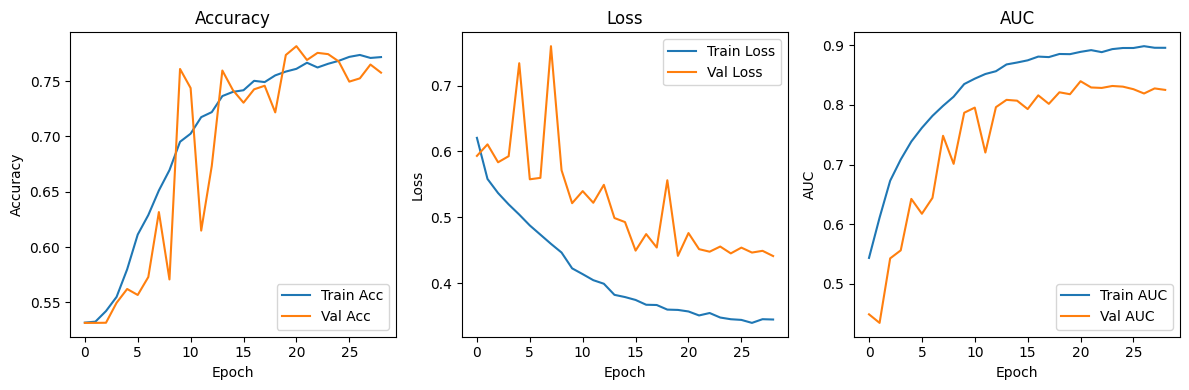

Training completed. Best model saved at: Pretrained Models/MobileNetV3/mobilenetv3_kidney_stone_model_trained.h5
Training plots saved in: Pretrained Models/MobileNetV3/training_plots


In [12]:
# Plot and save training metrics
# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(history.history['auc'], label='Train AUC')
plt.plot(history.history['val_auc'], label='Val AUC')
plt.legend()
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')

plt.tight_layout()
plt.savefig(f"{PLOTS_DIR}/training_metrics.png")
plt.show()

# Save the training history for later analysis
import json
with open(f"{PLOTS_DIR}/training_history.json", 'w') as f:
    # Convert numpy values to Python native types for JSON serialization
    history_dict = {k: [float(val) for val in v] for k, v in history.history.items()}
    json.dump(history_dict, f)

print(f"Training completed. Best model saved at: {SAVE_BEST_MODEL_PATH}")
print(f"Training plots saved in: {PLOTS_DIR}")

In [13]:
# Save the custom loss function with the model for future loading
# This is important for when you want to load the model later

# First, let's load the best model that was saved during training
with custom_object_scope({'focal_loss_fixed': focal_loss_fn}):
    best_model = load_model(SAVE_BEST_MODEL_PATH)

# Now save it again with the custom objects properly registered
best_model.save(SAVE_BEST_MODEL_PATH, save_format='h5')

print(f"Model saved with custom loss function at: {SAVE_BEST_MODEL_PATH}")

Model saved with custom loss function at: Pretrained Models/MobileNetV3/mobilenetv3_kidney_stone_model_trained.h5
